In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [ ]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
from tqdm import tqdm

# Đường dẫn đến thư mục
ANNOTATIONS_DIR = "/kaggle/input/face-mask-detection/annotations"
IMAGES_DIR = "/kaggle/input/face-mask-detection/images"

In [ ]:
VALID_LABELS = {"with_mask", "without_mask", "mask_weared_incorrect"}

data = []

for filename in tqdm(os.listdir(ANNOTATIONS_DIR)):
    if not filename.endswith(".xml"):
        continue
    path = os.path.join(ANNOTATIONS_DIR, filename)
    tree = ET.parse(path)
    root = tree.getroot()

    image_name = root.find("filename").text

    for obj in root.findall("object"):
        label = obj.find("name").text

        # Dùng nhãn gốc, bỏ qua nếu không hợp lệ
        if label not in VALID_LABELS:
            continue

        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        data.append({
            "image_path": os.path.join(IMAGES_DIR, image_name),
            "label": label,
            "xmin": xmin,
            "ymin": ymin,
            "xmax": xmax,
            "ymax": ymax
        })

df = pd.DataFrame(data)
df.head()

100%|██████████| 853/853 [00:05<00:00, 143.68it/s]


,image_path,label,xmin,ymin,xmax,ymax
0,/kaggle/input/face-mask-detection/images/makss...,with_mask,28,55,46,71
1,/kaggle/input/face-mask-detection/images/makss...,with_mask,98,62,111,78
2,/kaggle/input/face-mask-detection/images/makss...,mask_weared_incorrect,159,50,193,90
3,/kaggle/input/face-mask-detection/images/makss...,with_mask,293,59,313,80
4,/kaggle/input/face-mask-detection/images/makss...,with_mask,352,51,372,72


In [ ]:
import os
import cv2
from tqdm import tqdm

# Đường dẫn output
OUTPUT_DIR = "/kaggle/working/mask_dataset"

# Tạo thư mục cho từng nhãn
labels = df['label'].unique()
for label in labels:
    os.makedirs(os.path.join(OUTPUT_DIR, label), exist_ok=True)

# Duyệt từng dòng trong df để crop và lưu ảnh
for idx, row in tqdm(df.iterrows(), total=len(df)):
    img = cv2.imread(row['image_path'])
    if img is None:
        continue

    # Cắt khuôn mặt
    face = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]

    # Lưu ảnh vào folder tương ứng theo label
    out_path = os.path.join(OUTPUT_DIR, row['label'], f"{idx}.jpg")
    cv2.imwrite(out_path, face)


 14%|█▍        | 579/4072 [00:11<01:15, 46.00it/s]libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
100%|██████████| 4072/4072 [01:22<00:00, 49.55it/s]


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")


✅ Using device: cpu


In [ ]:
#khai báo transform để resize, augment, normalize

# Biến đổi dùng cho tập huấn luyện
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                   # Resize về input chuẩn của EfficientNetB0
    transforms.RandomHorizontalFlip(),               # Lật ngang ngẫu nhiên
    transforms.RandomRotation(10),                   # Xoay ±10 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Làm sáng/tối/màu ngẫu nhiên
    transforms.ToTensor(),                           # Chuyển về tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize chuẩn ImageNet
                         std=[0.229, 0.224, 0.225])
])

# Biến đổi dùng cho validation & test (không augment)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
# Load dataset đã lưu ở thư mục mask_dataset (phân theo label)
DATA_DIR = "/kaggle/working/mask_dataset"
full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)

# Chia train/val/test theo tỷ lệ 80/10/10
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Dùng random_split để chia
generator = torch.Generator().manual_seed(42)  # Đảm bảo chia giống nhau mỗi lần
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator)


In [ ]:
# Gán lại transform riêng cho val/test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms


# Tạo DataLoader cho mỗi tập
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Kiểm tra tổng số ảnh mỗi tập
print(f"✅ Loaded: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

#Hoàn thành chia tập dữ liệu train/val/test
#Hoàn thành tiền xử lý dữ liệu, chuyển qua bước LOAD TT EfficientNetB0

✅ Loaded: 3257 train, 407 val, 408 test


In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load EfficientNetB0 kiến trúc (không weights từ internet)
model = models.efficientnet_b0(weights=None)

# Load pretrained weights thủ công
model.load_state_dict(torch.load("/kaggle/input/efficientnet_b0_rwightman-7f5810bc.pth/pytorch/default/1/efficientnet_b0_rwightman-7f5810bc.pth"))

# Điều chỉnh classifier cho 3 lớp
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 3)

# Đưa model lên GPU (nếu có)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("✅ Loaded EfficientNetB0 từ file local thành công!")


✅ Loaded EfficientNetB0 từ file local thành công!


In [ ]:
#Cấu hình huấn luyện
import torch.optim as optim
from tqdm import tqdm

# Thiết bị sử dụng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hàm loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Số epoch
num_epochs = 10

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Chuyển sang chế độ train
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward & update
        optimizer.zero_grad()      # Reset gradient
        loss.backward()            # Tính gradient
        optimizer.step()           # Cập nhật trọng số

        # Tính toán loss và accuracy
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)            # Lấy label có xác suất cao nhất
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()  # Chế độ đánh giá (tắt dropout, batchnorm)
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Không tính gradient
        for images, labels in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [ ]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Hiển thị kết quả
        print(f"📉 Train Loss: {train_loss:.4f} | ✅ Train Acc: {train_acc:.4f}")
        print(f"📋 Val   Loss: {val_loss:.4f} | 🎯 Val   Acc: {val_acc:.4f}")

        # Lưu model mỗi epoch
        model_filename = f"efficientnet_epoch{epoch+1}_val{val_acc:.4f}.pth"
        torch.save(model.state_dict(), model_filename)
        print(f"💾 Saved: {model_filename}")

        # Lưu mô hình tốt nhất
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_efficientnet_b0.pth")
            print("🌟 New best model saved!")


In [ ]:
train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)

print("✅ Training completed!")


🔁 Epoch 1/10


Validating: 100%|██████████| 13/13 [00:13<00:00,  1.06s/it]


📉 Train Loss: 0.4640 | ✅ Train Acc: 0.8517
📋 Val   Loss: 0.2248 | 🎯 Val   Acc: 0.9214
💾 Saved: efficientnet_epoch1_val0.9214.pth
🌟 New best model saved!

🔁 Epoch 2/10


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.27s/it]


📉 Train Loss: 0.1479 | ✅ Train Acc: 0.9512
📋 Val   Loss: 0.1692 | 🎯 Val   Acc: 0.9386
💾 Saved: efficientnet_epoch2_val0.9386.pth
🌟 New best model saved!

🔁 Epoch 3/10


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.28s/it]


📉 Train Loss: 0.0866 | ✅ Train Acc: 0.9727
📋 Val   Loss: 0.1620 | 🎯 Val   Acc: 0.9484
💾 Saved: efficientnet_epoch3_val0.9484.pth
🌟 New best model saved!

🔁 Epoch 4/10


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.29s/it]


📉 Train Loss: 0.0543 | ✅ Train Acc: 0.9850
📋 Val   Loss: 0.1522 | 🎯 Val   Acc: 0.9558
💾 Saved: efficientnet_epoch4_val0.9558.pth
🌟 New best model saved!

🔁 Epoch 5/10


Validating: 100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


📉 Train Loss: 0.0405 | ✅ Train Acc: 0.9889
📋 Val   Loss: 0.1587 | 🎯 Val   Acc: 0.9607
💾 Saved: efficientnet_epoch5_val0.9607.pth
🌟 New best model saved!

🔁 Epoch 6/10


Validating: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


📉 Train Loss: 0.0297 | ✅ Train Acc: 0.9908
📋 Val   Loss: 0.1577 | 🎯 Val   Acc: 0.9533
💾 Saved: efficientnet_epoch6_val0.9533.pth

🔁 Epoch 7/10


Validating: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it]


📉 Train Loss: 0.0212 | ✅ Train Acc: 0.9945
📋 Val   Loss: 0.1421 | 🎯 Val   Acc: 0.9582
💾 Saved: efficientnet_epoch7_val0.9582.pth

🔁 Epoch 8/10


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.22s/it]


📉 Train Loss: 0.0136 | ✅ Train Acc: 0.9966
📋 Val   Loss: 0.1536 | 🎯 Val   Acc: 0.9607
💾 Saved: efficientnet_epoch8_val0.9607.pth

🔁 Epoch 9/10


Validating: 100%|██████████| 13/13 [00:15<00:00,  1.23s/it]


📉 Train Loss: 0.0230 | ✅ Train Acc: 0.9945
📋 Val   Loss: 0.1325 | 🎯 Val   Acc: 0.9631
💾 Saved: efficientnet_epoch9_val0.9631.pth
🌟 New best model saved!

🔁 Epoch 10/10


Validating: 100%|██████████| 13/13 [00:16<00:00,  1.26s/it]


📉 Train Loss: 0.0116 | ✅ Train Acc: 0.9972
📋 Val   Loss: 0.1662 | 🎯 Val   Acc: 0.9459
💾 Saved: efficientnet_epoch10_val0.9459.pth
✅ Training completed!


In [ ]:
# Load mô hình tốt nhất
model.load_state_dict(torch.load("best_efficientnet_b0.pth"))
model.eval()
model = model.to(device)

# Hàm đánh giá
def evaluate_model(model, test_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total
    print(f"🎯 Test Accuracy: {acc:.4f}")
    return acc

# Gọi đánh giá
evaluate_model(model, test_loader, device)
#kết quả test trên tập test:

🎯 Test Accuracy: 0.9681


0.9681372549019608

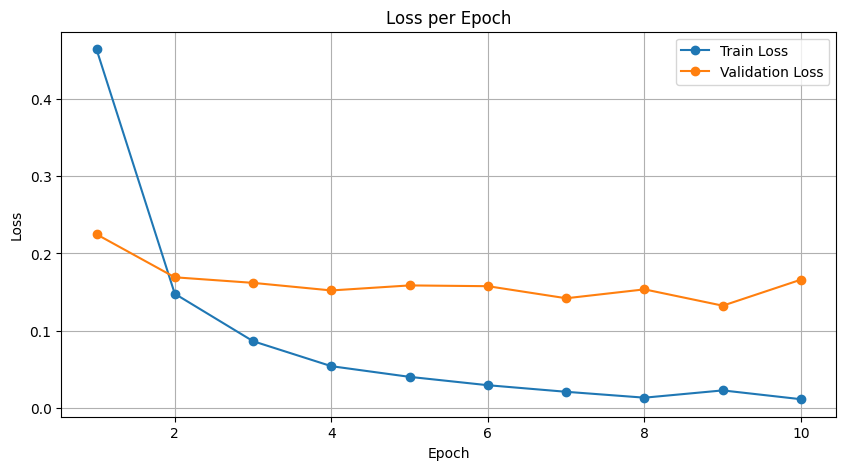

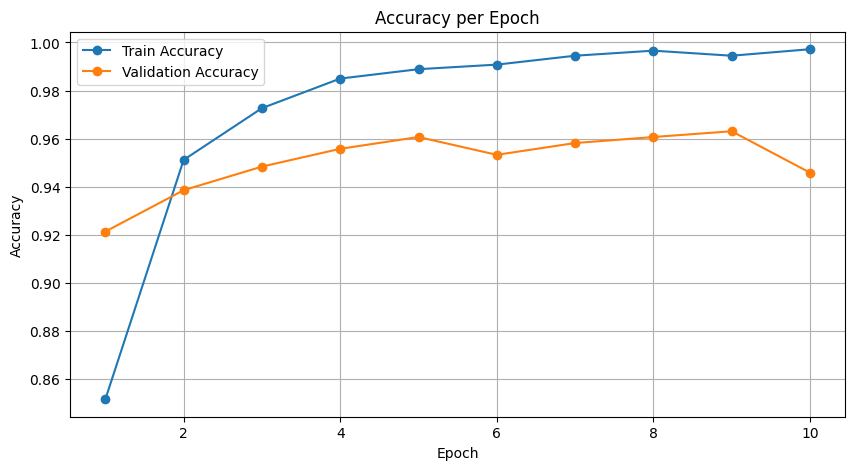

In [ ]:
#Ghi lại losses/accuracy từ 10 epoch train ở trên
train_accuracies = [0.8517, 0.9512, 0.9727, 0.9850, 0.9889, 0.9908, 0.9945, 0.9966, 0.9945, 0.9972]
val_accuracies = [0.9214, 0.9386, 0.9484, 0.9558, 0.9607, 0.9533, 0.9582, 0.9607, 0.9631, 0.9459]
train_losses = [0.4640, 0.1479, 0.0866, 0.0543, 0.0405, 0.0297, 0.0212, 0.0136, 0.0230, 0.0116]
val_losses = [0.2248, 0.1692, 0.1620, 0.1522, 0.1587, 0.1577, 0.1421, 0.1536, 0.1325, 0.1662]

import matplotlib.pyplot as plt

epochs = list(range(1, len(train_accuracies) + 1))

# --- Biểu đồ Loss ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# --- Biểu đồ Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!zip efficientnet_model.zip best_efficientnet_b0.pth

updating: best_efficientnet_b0.pth (deflated 8%)


In [ ]:
from IPython.display import FileLink
FileLink('efficientnet_model.zip')


/kaggle/working/efficientnet_model.zip